<h1 style="text-align:center;"> Loan Approval Prediction - Season 4, Episode 10</h1>

<div style="display: flex; flex-direction: row; align-items: center;">
    <div style="flex: 0; margin-top: 8px;">
        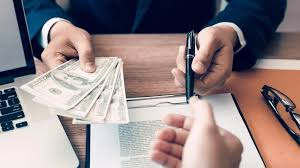
    </div>
    <div style="flex: 1; margin-left: 30px; margin-top: 6px">
        <p>This notebook is about the kaggle competetion named <b> Loan Approval Prediction
Playground Series - Season 4, Episode 10</b> . The goal for this competition is to predict whether an applicant is approved for a loan using the area under the ROC curve evaluation method.
        </p>
    </div>
</div>

In [121]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import  train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform, truncnorm, randint

import xgboost as xgb

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## 1. Exploratory Data Analysis (EDA) <a name="eda"></a>

In [160]:
path="./Data/"
train=pd.read_csv(path+'train.csv')
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


The target variable is loan_status, where 0 means that the loan was not aproved and 1 otherwise.

In [161]:
test=pd.read_csv(path+'test.csv')
test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


Now we see whether there are Null values in the train and test datasets.

In [162]:
train.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [163]:
test.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

As we can see, there are no Null values.

Since `loan_status` is our target variable, let's explore it.

<Axes: xlabel='loan_status', ylabel='count'>

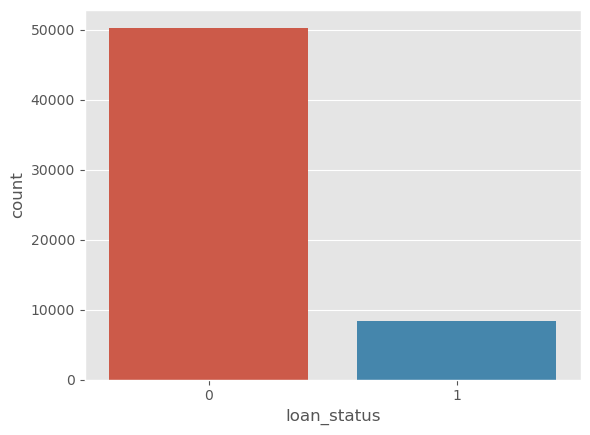

In [164]:
plt.style.use('ggplot')
sns.countplot(train,x='loan_status')

There are much more data on non approved Loans. 

Let's see the numerical variables that are correlated with `loan_status`.

<Axes: >

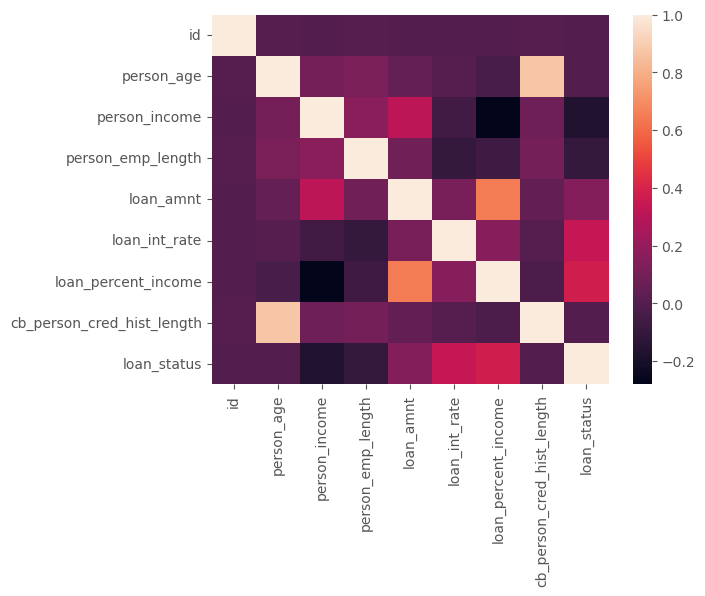

In [165]:
corr=train.select_dtypes('number').corr()
sns.heatmap(corr)

Focusing on the last column, we observe a (reasonably) high positive correlation with  `loan_int_rate` and `loan_percent_income`. On the other hand, there is a slight negative correlation with `person_income`,  meaning that poorer people have a little more chance of getting a loan.

In [166]:
# Here we separate the numerical columns and the categorical columns

number_columns=train.drop('id',axis=1).select_dtypes('number').columns.to_list()
categorical_columns=train.select_dtypes(exclude='number').columns.to_list()
print('Numerical columns: ', number_columns)
print('Categorical columns: ', categorical_columns)

Numerical columns:  ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']
Categorical columns:  ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


Next, let's look into the categorical variables and see its relation with the `loan_status` target.

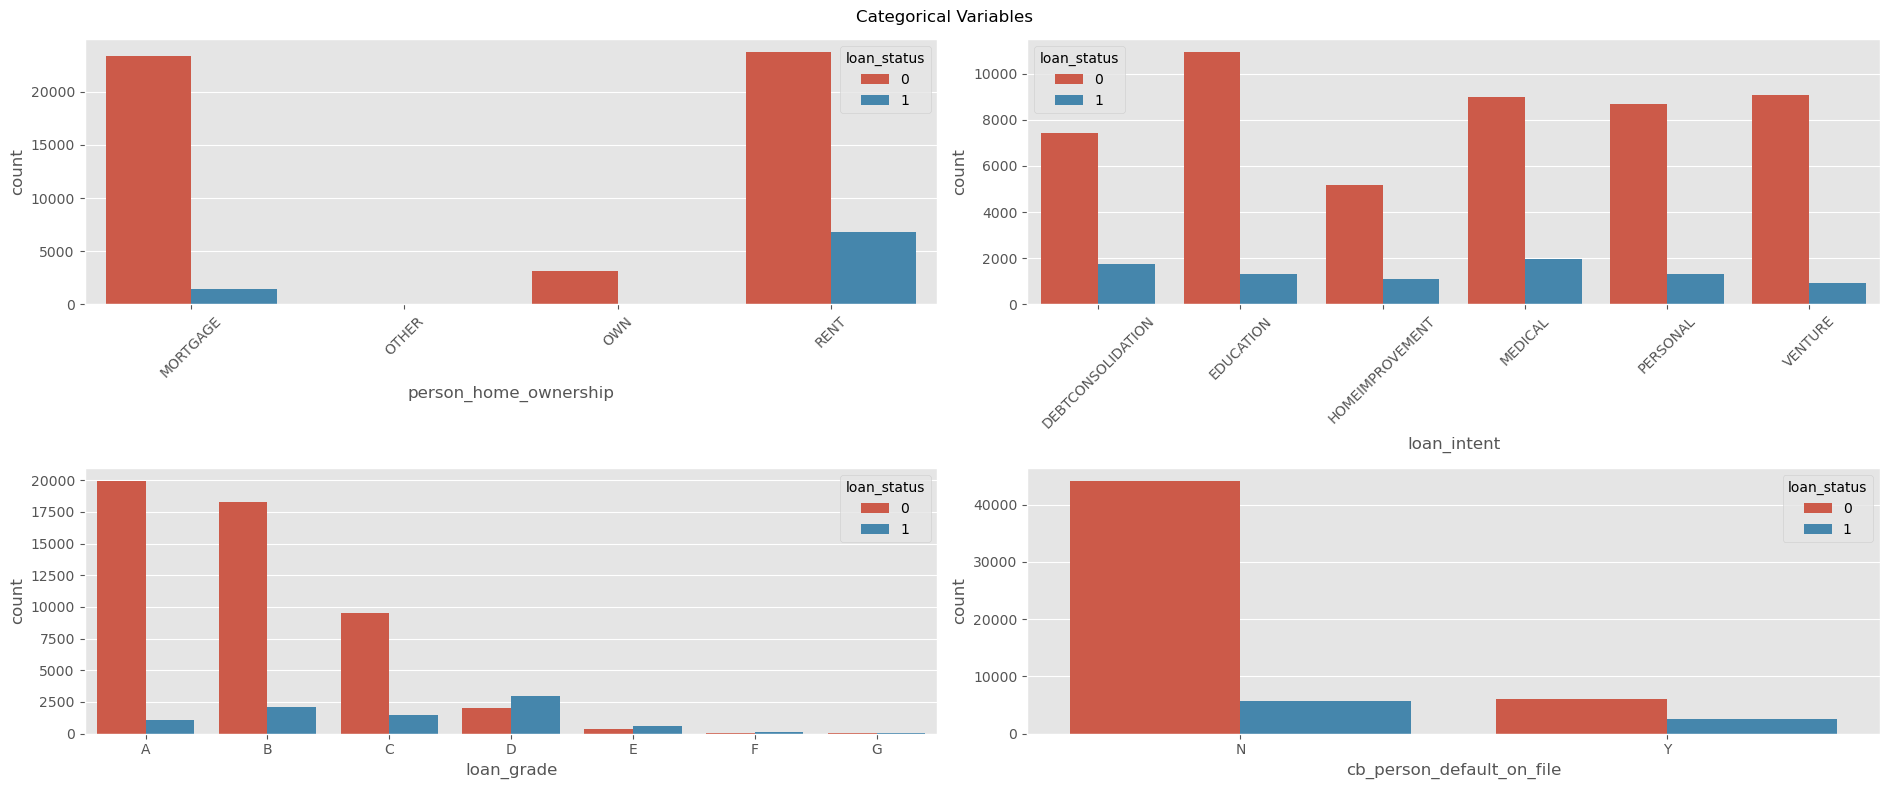

In [167]:
f,ax=plt.subplots(2,2,figsize=(19,8))
ax = ax.flatten()
for i,column in enumerate(categorical_columns):
    sorted_categories = sorted(train[column].unique())
    sns.countplot(data=train,x= column,hue='loan_status',ax=ax[i],order=sorted_categories)
    if i in [0,1]:    
        ax[i].tick_params(axis='x', rotation=45)
plt.suptitle('Categorical Variables')
plt.tight_layout()
plt.show()

There are a few things we can observe here. For example, as the `loan_grade` increases, so the probability of a loan being approved. Same when `cb_person_default_on_file` is Y when compared to N. 

Let's do a pairplot of the numerical columns using `loan_status` as the color, to have a little more insight than just the correlation metric we provided before.

c:\Users\Rodrigo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


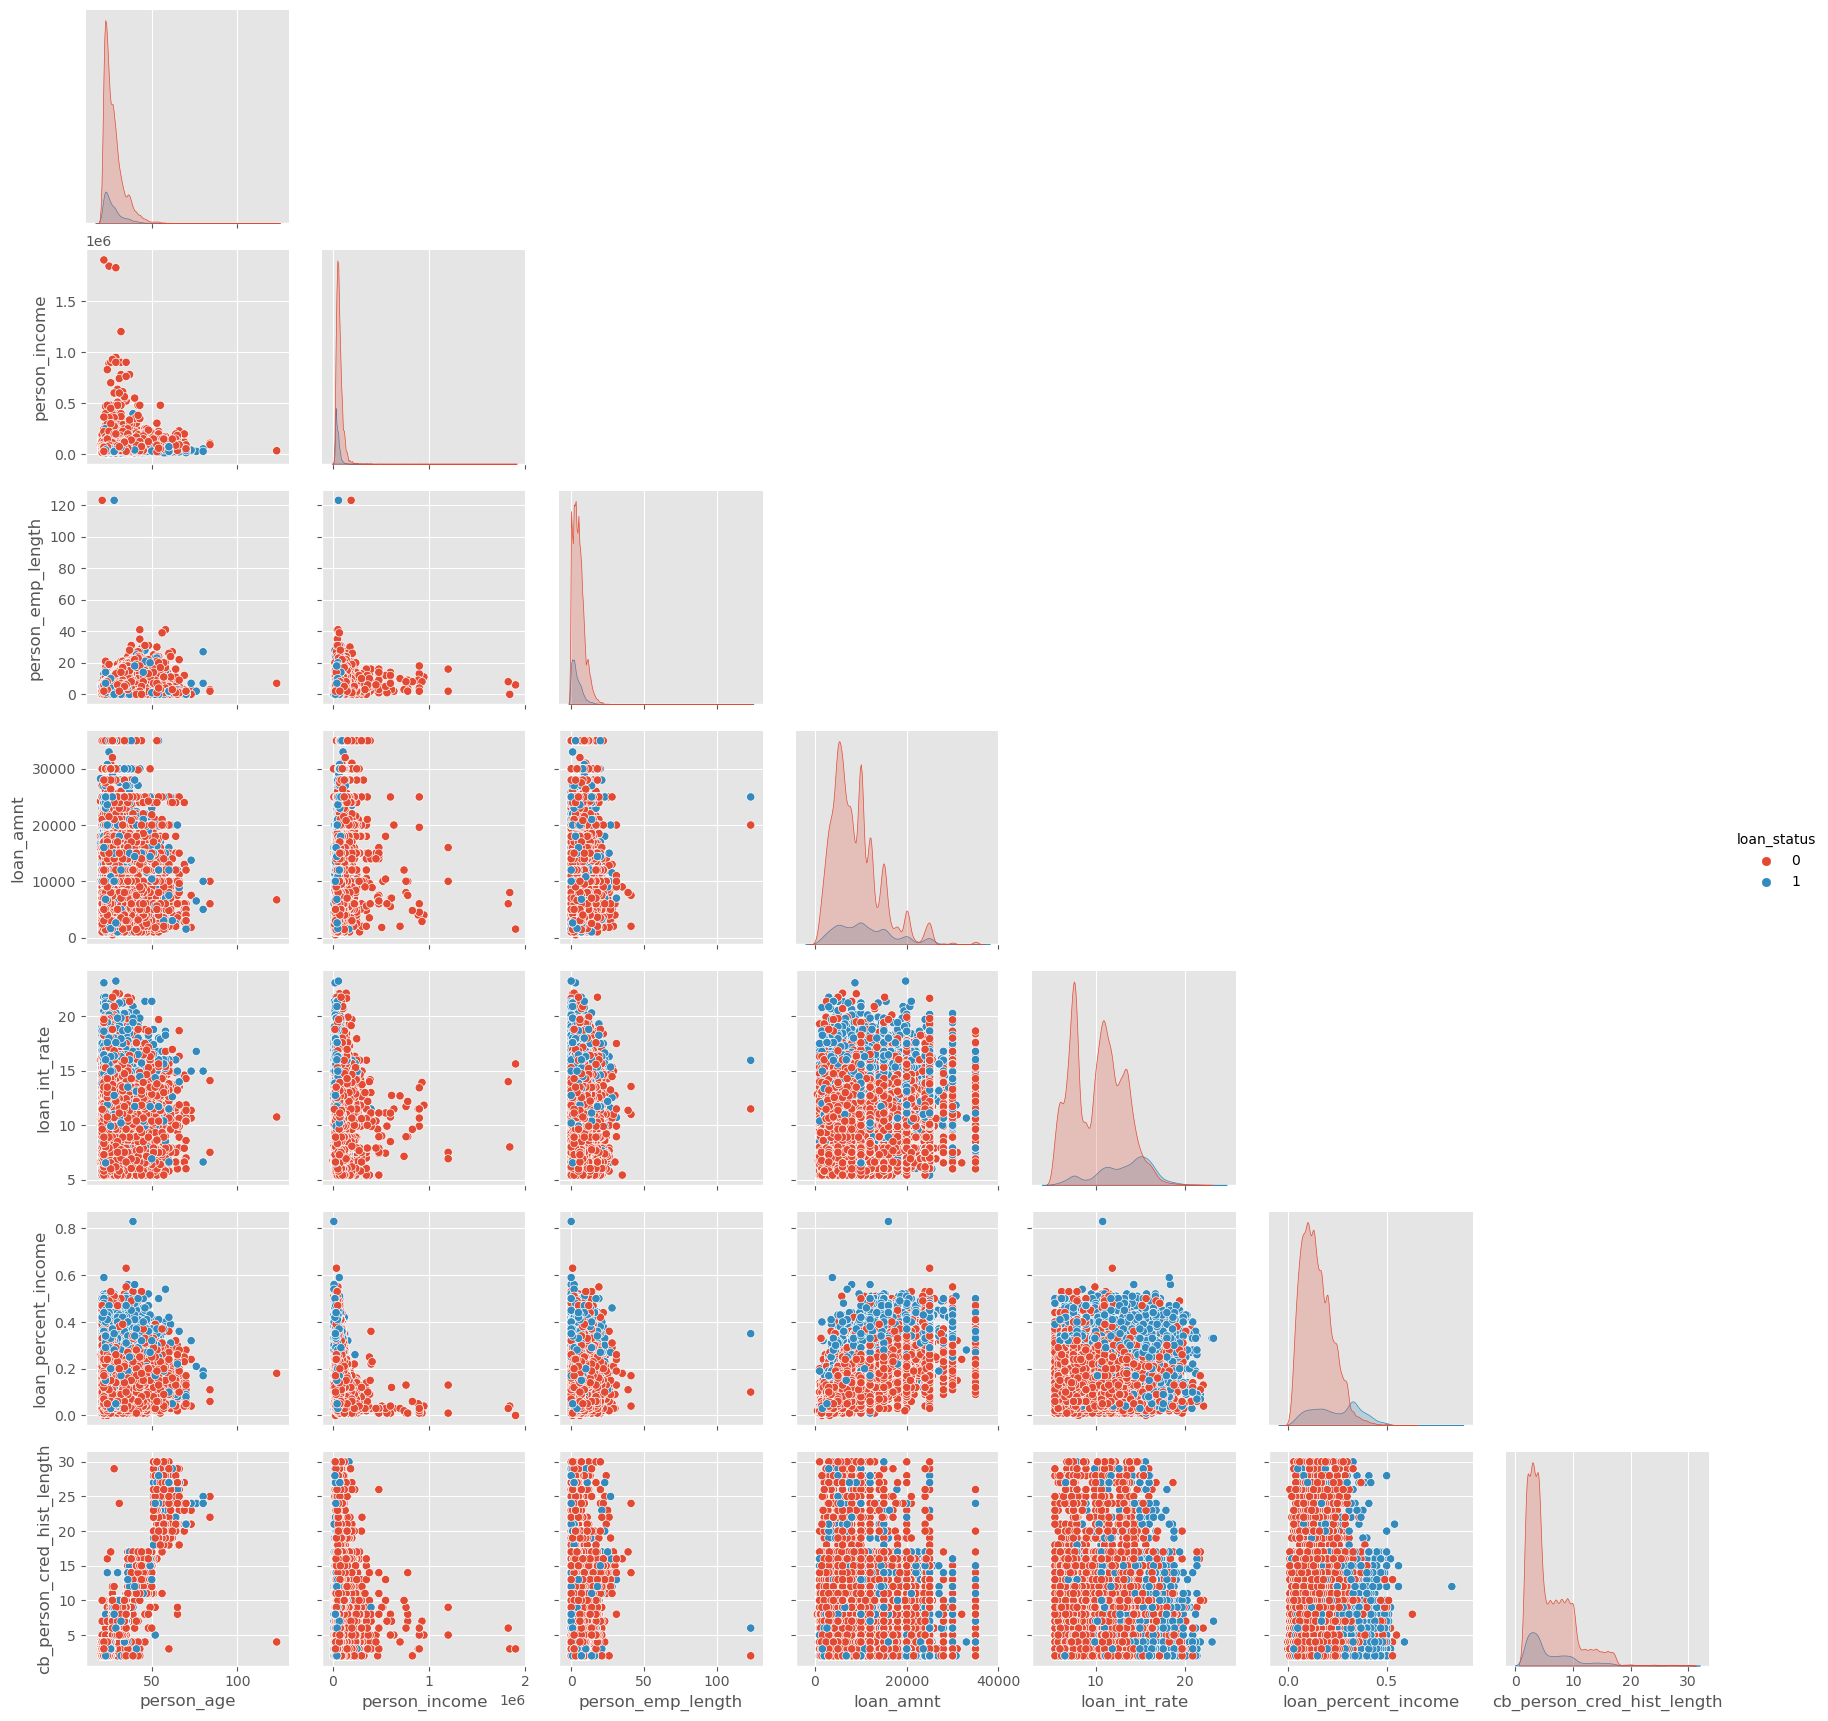

In [168]:
sns.pairplot(train[number_columns],hue='loan_status',corner=True)
# This can take a couple of minutes.

## 2. Modeling <a name="model"></a>

We start by taking out the id column (that does not provide any information) from the train dataset and separating the features from the target variable. 

In [67]:
X=train.drop(['id','loan_status'],axis=1)
y=train['loan_status']

Now, to use our categorical variables in our models, we need to One hot encode them, creating multiple columns for each categorical feature.

In [69]:
X=pd.get_dummies(X,columns=categorical_columns)
X.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,37,35000,0.0,6000,11.49,0.17,14,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,22,56000,6.0,4000,13.35,0.07,2,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,29,28800,8.0,6000,8.90,0.21,10,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3,30,70000,14.0,12000,11.11,0.17,5,0,0,0,...,1,0,1,0,0,0,0,0,1,0
4,22,60000,2.0,6000,6.92,0.10,3,0,0,0,...,0,1,0,0,0,0,0,0,1,0


Since we want to evaluate everything first in our train dataset ( the test we will send to kaggle for evaluation way later), we split this dataset in a train and test dataset. I guess one would call it a train_train and train_test dataset :P 

In [71]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, stratify=y,random_state=10)

We used stratify because as we observed before, our data is highly unbalanced, so to preserve this proportion we use this keyword.

Next we use a deploy a few models and observe the area under the ROC curve as a parameter to further evaluate the chosen model.

### 2.1 Logistic Regression, XGboost and Decision Tree

In [156]:
Logreg = LogisticRegression()
Logreg.fit(X_train,y_train)
roc_auc_score(y_test,Logreg.predict(X_test))

0.6529398703338923

In [157]:
xgboost_baseline = xgb.XGBClassifier(objective='binary:logistic')

xgboost_baseline.fit(X_train,
            y_train)
roc_auc_score(y_test,xgboost_baseline.predict(X_test))

0.8610490322665137

In [158]:
tree_baseline = DecisionTreeClassifier()
tree_baseline.fit(X_train,y_train)
roc_auc_score(y_test,tree_baseline.predict(X_test))

0.8306989063924045

XGboost seem to be doing the best here, which makes sense as a very powerful machine learning algorithm.

## 3. Hyperparameter Tuning <a name='hyper'> </a>

For information in regard to hyperparameter tuning for XGboost see [A Guide on XGBoost hyperparameters tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning). We are going to use only the following parameters `[max_depth, eta, gamma, lambda, scale_pos_weight]`. What each one of these parameters means are explained in the above link.

We will be using RandomSearch for this section.

In [102]:
model_params = {
    
    'max_depth': randint(3,10),
    'eta': uniform(0.01,0.2),
    'gamma': uniform(0, 1),
    'lambda': randint(0,10) ,
    'scale_pos_weight': randint(1,5),
}

clf = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic'), model_params, n_iter=100, cv=5, random_state=1,scoring='roc_auc')

clf.fit(X_train,y_train)
roc_auc_score(y_test,clf.predict(X_test))

0.8690450592998314

In [104]:
clf.best_params_

{'eta': 0.19372035559550518,
 'gamma': 0.00040202489135743313,
 'lambda': 3,
 'max_depth': 4,
 'scale_pos_weight': 2}

This is slightly better than the default one. Just so we see how a very good tuning is, let's use the implementation described in [A Guide on XGBoost hyperparameters tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning) using Bayesian Optimization, with a few modification in regard to which hyperparameter to tune and the scoring method.

In [146]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'eta': hp.uniform('eta', 0.01,0.2),
        'lambda' : hp.uniform('lambda', 0,1),
        'scale_pos_weight': hp.quniform('scale_pos_weight',1,5,1),
        'seed': 0
    }

In [147]:
def objective(space):
    clf_v2=xgb.XGBClassifier( max_depth = int(space['max_depth']), gamma = space['gamma'],
                    eta = space['eta'], reg_lambda =space['lambda'],scale_pos_weight=space['scale_pos_weight'], 
                    eval_metric="auc", early_stopping_rounds=10)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf_v2.fit(X_train, y_train,
            eval_set=evaluation,verbose=False)
    

    pred = clf_v2.predict(X_test)
    accuracy = roc_auc_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [148]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.8734784531741765                                     
SCORE:                                                                            
0.855455179709177                                                                 
SCORE:                                                                            
0.849616275947955                                                                 
SCORE:                                                                            
0.862407365406378                                                                 
SCORE:                                                                            
0.8716079621252574                                                                
SCORE:                                                                            
0.8783092925392878                                                                
SCORE:                                                    

In [149]:
best_hyperparams

{'eta': 0.15953271757044502,
 'gamma': 8.966257410661362,
 'lambda': 0.1699265505788579,
 'max_depth': 8.0,
 'scale_pos_weight': 5.0}

This means that with these Hyperparameters we have a ROC score of 0.8879514457515032, as stated in the best loss above. But just for us to verify it let's use these hyperparameters.

In [150]:
best_hyperparams['max_depth']=int(best_hyperparams['max_depth'])

In [151]:
clf_v2=xgb.XGBClassifier(n_estimators =180,**best_hyperparams,  eval_metric="auc", early_stopping_rounds=10)
    
evaluation = [( X_train, y_train), ( X_test, y_test)]
    
clf_v2.fit(X_train, y_train, eval_set=evaluation,verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eta=0.15953271757044502,
              eval_metric='auc', feature_types=None, gamma=8.966257410661362,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.1699265505788579,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=180,
              n_jobs=None, ...)

In [152]:
roc_auc_score(y_test,clf_v2.predict(X_test))

0.8879514457515032

## 4. Submission

First we need to take the features from the test dataset and expand the categorical features using One Hot Encoding like we did for the test dataset.

In [173]:
X_final=test.drop('id',axis=1)
X_final=pd.get_dummies(X_final,columns=categorical_columns)
submission=pd.read_csv(path+'sample_submission.csv')
submission['loan_status']=clf_v2.predict(X_final)


In [174]:
submission.head()

,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,0


In [175]:
submission.to_csv(path+'submission.csv', index=False)

![image info](./Data/Capture.png)

As the image shows, for the test dataset, my submission results in a score of 0.88650. It could be better. We used a very good model and a nice way to tune the hyperparameters. But we could have done some feature engineering, done more data exploration to drop outliers, maybe other models would have done even better than XGboost.